# Define baseline model

Com base nas nossas regras de negócio vamos definir o modelo baseline, vamos aplicar um modelo simples e analisar como ele prever nossas variáveis. 

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from typing import Union

## 1 - Leitura dos dados

In [2]:
df = pd.read_csv("../data/raw/customer_churn_data - customer_churn_data.csv",decimal=",")
print("DataFrame shape: ",df.shape)
df.head()

DataFrame shape:  (7043, 22)


,ID,Tipo de empresa,Fundação da empresa,Possui mais de um sócio,Funcionários,Meses de permanência,Utiliza serviços financeiros,PossuiContador,Faz conciliação bancária,Frequência de utilização de feature do sistema: Módulo financeiro,...,Frequência de utilização de feature do sistema: Módulo de vendas,Frequência de utilização de feature do sistema: Relatórios,Frequência de utilização de feature do sistema: Utilização de APIs de integração,Contrato,Emite boletos,Emite boletos.1,Tipo de pagamento,Receita mensal,Receita total,Churn
0,1,Micro empresa,2016,Sim,até 5 funcionários,1,Não,NaN,automática,Pouco uso,...,Pouco uso,Pouco uso,Pouco uso,Mês-a-mês,1,Yes,Boleto - pagamento único,"R$ 29,85","R$ 29,85",Não
1,2,Pequena empresa,2018,Não,até 5 funcionários,34,Sim,Não,automática,Uso frequente,...,Pouco uso,Pouco uso,Pouco uso,Trimestral,0,No,Boleto - mês a mês,"R$ 56,95","R$ 1.889,50",Não
2,3,Pequena empresa,2021,Não,até 5 funcionários,2,Sim,Não,automática,Uso frequente,...,Pouco uso,Pouco uso,Pouco uso,Mês-a-mês,1,Yes,Boleto - mês a mês,"R$ 53,85","R$ 108,15",Sim
3,4,Pequena empresa,2016,Não,até 5 funcionários,45,Não,NaN,automática,Uso frequente,...,Uso frequente,Pouco uso,Pouco uso,Trimestral,0,No,Cartão de crédito - pagamento único,"R$ 42,30","R$ 1.840,75",Não
4,5,Micro empresa,2017,Não,até 5 funcionários,2,Sim,Não,manual,Pouco uso,...,Pouco uso,Pouco uso,Pouco uso,Mês-a-mês,1,Yes,Boleto - pagamento único,"R$ 70,70","R$ 151,65",Sim


## 2 - Limpando e tratando dados

In [3]:
def clear_numeric_strings(dataframe:pd.DataFrame,subset=Union[str,list]):
    new_df = dataframe.copy()
    if isinstance(subset,str):
        new_df[subset] = new_df[subset].str.replace(pat=r"([R$])|([.])",repl="",regex=True)\
                                               .str.strip()\
                                               .str.replace(pat=",",repl=".")
    else:
        new_df[subset] = new_df[subset].apply(
            func=lambda s: s.str.replace(pat=r"([R$])|([.])",repl="",regex=True)\
                                               .str.strip()\
                                               .str.replace(pat=",",repl="."),
            axis=1,
        )
    return new_df
        
def convert_to_numeric(dataframe:pd.DataFrame,subset:Union[str,list]):
    new_df = dataframe.copy()
    new_df[subset]=new_df[subset].astype("float")
    return new_df


conv_cols = ["Receita mensal","Receita total"]
df = clear_numeric_strings(dataframe=df,subset=conv_cols)
df = convert_to_numeric(dataframe=df,subset=conv_cols)
df = df.drop("Emite boletos",axis=1)
df.head()

,ID,Tipo de empresa,Fundação da empresa,Possui mais de um sócio,Funcionários,Meses de permanência,Utiliza serviços financeiros,PossuiContador,Faz conciliação bancária,Frequência de utilização de feature do sistema: Módulo financeiro,...,Frequência de utilização de feature do sistema: Integração bancária,Frequência de utilização de feature do sistema: Módulo de vendas,Frequência de utilização de feature do sistema: Relatórios,Frequência de utilização de feature do sistema: Utilização de APIs de integração,Contrato,Emite boletos.1,Tipo de pagamento,Receita mensal,Receita total,Churn
0,1,Micro empresa,2016,Sim,até 5 funcionários,1,Não,NaN,automática,Pouco uso,...,Pouco uso,Pouco uso,Pouco uso,Pouco uso,Mês-a-mês,Yes,Boleto - pagamento único,29.85,29.85,Não
1,2,Pequena empresa,2018,Não,até 5 funcionários,34,Sim,Não,automática,Uso frequente,...,Uso frequente,Pouco uso,Pouco uso,Pouco uso,Trimestral,No,Boleto - mês a mês,56.95,1889.50,Não
2,3,Pequena empresa,2021,Não,até 5 funcionários,2,Sim,Não,automática,Uso frequente,...,Pouco uso,Pouco uso,Pouco uso,Pouco uso,Mês-a-mês,Yes,Boleto - mês a mês,53.85,108.15,Sim
3,4,Pequena empresa,2016,Não,até 5 funcionários,45,Não,NaN,automática,Uso frequente,...,Uso frequente,Uso frequente,Pouco uso,Pouco uso,Trimestral,No,Cartão de crédito - pagamento único,42.30,1840.75,Não
4,5,Micro empresa,2017,Não,até 5 funcionários,2,Sim,Não,manual,Pouco uso,...,Pouco uso,Pouco uso,Pouco uso,Pouco uso,Mês-a-mês,Yes,Boleto - pagamento único,70.70,151.65,Sim


In [4]:
def convert_to_categoric(dataframe:pd.DataFrame,subset:Union[str,list]):
    new_df = dataframe.copy()
    new_df[subset]=new_df[subset].astype("category")
    return new_df

cat_columns = list(df.select_dtypes(include="object",exclude=["float64","int64"]).columns)
df = convert_to_categoric(dataframe=df,subset=cat_columns)
df.dtypes

ID                                                                                     int64
Tipo de empresa                                                                     category
Fundação da empresa                                                                    int64
Possui mais de um sócio                                                             category
Funcionários                                                                        category
Meses de permanência                                                                   int64
Utiliza serviços financeiros                                                        category
PossuiContador                                                                      category
Faz conciliação bancária                                                            category
Frequência de utilização de feature do sistema: Módulo financeiro                   category
Frequência de utilização de feature do sistema: Emissão de nota fiscal

## 3 - Agregando algumas features

Agrupando dados da feature `Meses de permanência`

In [5]:
def classify_col(dataframe:pd.DataFrame,col_to_clf:str,new_col_name:str,map:dict):
    new_df = df.copy()
    new_df[new_col_name]=np.nan
    for cat,range in map.items():
        values = dataframe[col_to_clf].isin(range)
        new_df[new_col_name]=new_df[new_col_name].mask(values,cat)
    return new_df

In [6]:
map_temp_perm = {
    "Menor que 3 meses":range(0,3),
    "Entre 3 a 12 meses":range(3,12),
    "Entre 12 a 36 meses":range(12,36),
    "Maior que 36 meses":range(36,100),
}

df = classify_col(dataframe=df,col_to_clf="Meses de permanência ",new_col_name="clf_meses_permanência",map=map_temp_perm)
df = convert_to_categoric(dataframe=df,subset="clf_meses_permanência")
df["clf_meses_permanência"].value_counts()

clf_meses_permanência
Maior que 36 meses     3051
Entre 12 a 36 meses    1923
Entre 3 a 12 meses     1207
Menor que 3 meses       862
Name: count, dtype: int64

In [7]:
cols_freq = [
"Frequência de utilização de feature do sistema: Módulo financeiro",
"Frequência de utilização de feature do sistema: Emissão de nota fiscal",
"Frequência de utilização de feature do sistema: Integração bancária",
"Frequência de utilização de feature do sistema: Módulo de vendas",
"Frequência de utilização de feature do sistema: Relatórios",
"Frequência de utilização de feature do sistema: Utilização de APIs de integração"
]
df["quantidade_PoucoUso_features"] = df[cols_freq].map(
    func=lambda d: 1 if d=="Pouco uso" else 0,
).agg("sum",axis=1)

df["quantidade_PoucoUso_features"].value_counts()

quantidade_PoucoUso_features
0    1810
3    1118
4    1033
5     966
2     852
6     693
1     571
Name: count, dtype: int64

In [8]:
# Vamos remover algumas variavéis para remover dados repetidos 

df = df.drop(labels=cols_freq+["Meses de permanência ","ID"],axis=1)
df.columns

Index(['Tipo de empresa', 'Fundação da empresa', 'Possui mais de um sócio',
       'Funcionários', 'Utiliza serviços financeiros', 'PossuiContador',
       'Faz conciliação bancária', 'Contrato', 'Emite boletos.1',
       'Tipo de pagamento', 'Receita mensal', 'Receita total', 'Churn',
       'clf_meses_permanência', 'quantidade_PoucoUso_features'],
      dtype='object')

## 4 - Separando os dados de treinamento e validação

In [9]:
TARGET = "Churn"
CAT_FEATURES = list(df.select_dtypes(include=["category"],exclude=["int64","float64"]).columns)
CAT_FEATURES.remove(TARGET)
NUM_FEATURES = list(df.select_dtypes(include=["int64","float64"],exclude=["category"]).columns)
FEATURES = CAT_FEATURES+NUM_FEATURES

In [10]:
X = df[FEATURES]
y = df[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train, y_train shape:",(X_train.shape,y_train.shape))
print("X_test, y_test:",(X_test.shape,y_test.shape))

X_train, y_train shape: ((5634, 14), (5634,))
X_test, y_test: ((1409, 14), (1409,))


## 5 - Aplicando regra de negócio

Vamos considerar que o Churn será feito para empresas com menos de 12 meses de tempo de permanância e a quantidade de features com pouco uso é maior do que 3.

In [11]:
print("Proporção de Churn nos dados de treino:")
y_train.value_counts(normalize=True)

Proporção de Churn nos dados de treino:


Churn
Não    0.734469
Sim    0.265531
Name: proportion, dtype: float64

In [17]:
heuristic_predict = ((X_test["quantidade_PoucoUso_features"]>=3)&(
    (X_test["clf_meses_permanência"]=="Menos que 3 meses")|
    (X_test["clf_meses_permanência"]=="Entre 3 a 12 meses")
)).map({False:"Não",True:"Sim"})

heuristic_predict.value_counts(normalize=True)

Não    0.882896
Sim    0.117104
Name: proportion, dtype: float64

In [18]:
print(classification_report(y_test, heuristic_predict, target_names=['non-churn', 'churn']))

              precision    recall  f1-score   support

   non-churn       0.76      0.92      0.83      1036
       churn       0.48      0.21      0.30       373

    accuracy                           0.73      1409
   macro avg       0.62      0.57      0.57      1409
weighted avg       0.69      0.73      0.69      1409



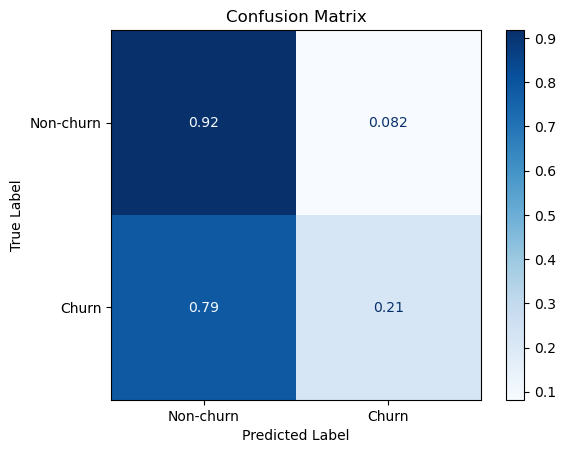

In [19]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, heuristic_predict, normalize='true')

# Define the class labels
labels = ['Non-churn', "Churn"]  # Replace with your class labels

# Create a confusion matrix display
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

# Plot the confusion matrix
cm_display.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## 6 - Decision Tree com as features atuais

In [24]:
# Define the pipeline
# Create the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), NUM_FEATURES),
        ('cat', OneHotEncoder(), CAT_FEATURES)])

# Define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Preprocessing (imputation + one-hot encoding)
    ('model', DecisionTreeClassifier(class_weight='balanced'))  # Model
])

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['Fundação da empresa',
                                                   'Receita mensal',
                                                   'Receita total',
                                                   'quantidade_PoucoUso_features']),
                                                 ('cat', OneHotEncoder(),
                                                  ['Tipo de empresa',
                                                   'Possui mais de um sócio',
                                                   'Funcionários',
                                                   'Utiliza serviços '
                                                   'financeiros',
                                                   'PossuiContador',
                                                   'Faz conciliação bancária',
                                                   'Contrato',
                                                   'Emite boletos.1',
                                                   'Tipo de pagamento',
                                                   'clf_meses_permanência'])])),
                ('model', DecisionTreeClassifier(class_weight='balanced'))])

In [25]:
y_pred_class = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

         Não       0.81      0.81      0.81      1036
         Sim       0.47      0.46      0.47       373

    accuracy                           0.72      1409
   macro avg       0.64      0.64      0.64      1409
weighted avg       0.72      0.72      0.72      1409



In [29]:
cat,ncat = np.unique(y_pred_class,return_counts=True)
for cat, qty in zip(cat,ncat):
    print(f"{cat}:{qty/np.sum(ncat,axis=0)}")

Não:0.7388218594748048
Sim:0.26117814052519517


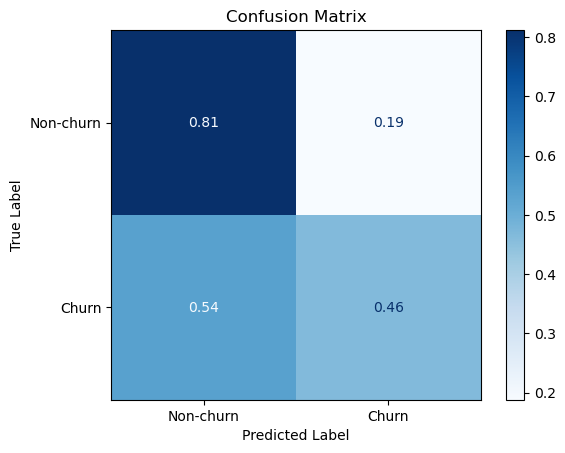

In [28]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_class, normalize='true')

# Define the class labels
labels = ['Non-churn', "Churn"]  # Replace with your class labels

# Create a confusion matrix display
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

# Plot the confusion matrix
cm_display.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## 7 - Conclusão

- Construímos duas baselines: 1 - a partir do modelo de negócio e 2 - com uma decision tree simples e features base ('Tipo de empresa','Fundação da empresa', 'Possui mais de um sócio', 'Funcionários', 'Utiliza serviços financeiros', 'PossuiContador','Faz conciliação bancária', 'Contrato', 'Emite boletos.1','Tipo de pagamento', 'Receita mensal', 'Receita total', 'Churn','clf_meses_permanência', 'quantidade_PoucoUso_features')
- A principal métrica para se acompanhar aqui é a f1-score: em problemas de Churn queremos um balanço entre precision e recall. Precision pois ela diminui a quantidade de falsos positivos (nesse caso, se previu o Churn mas a empresa não fez Churn) isso diminui o custo de manter um cliente, já o recall é importante pois ele diminui a quantidade de falsos negativos (não se prevê o Churn mas ocorre Churn) o que diminui a quantidade de perdas por desligamentos. Sendo assim, ambos os casos são importantes de evitar por isso se escolhe a f1-score para melhorar.
- o modelo 1 baseado em regra de negócio vimos que temos um forte bias para não classificar o Churn, logo, para previsão de Churn obtemos: precision: 0.48, recall: 0.21 e f1-score:0.3
- O modelo 2 baseado em ML e features base já apresentou uma melhora no recall e f1-score para previsão de Churn, os resultados obtidos (precision: 0.47, recall: 0.46 e f1-score:0.47) mostram que realizando um tunning e obter resultados ainda melhores.